In [7]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import cm
%matplotlib inline
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import datetime
from matplotlib.colors import TwoSlopeNorm
import json
import geopandas as gpd
import requests
import plotly.express as px
from shapely import wkt
import os
import geojson
import csv

from natsort import natsorted
from PIL import Image

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
font = {'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

In [9]:
pd.set_option('display.max_rows', 500)

In [10]:
res='results_flu/'

## Read flu data (split by Saisonwoche)

In [12]:
# reading input data 

# incidence data of the seasonal flu, starting from calender week 27 2019 and continuing for 53 weeks in total
df_flu=pd.read_excel('data/Data_flu.xlsx')

df_flu.head(2)

,Kreis,SW01,SW02,SW03,SW04,SW05,SW06,SW07,SW08,SW09,...,SW44,SW45,SW46,SW47,SW48,SW49,SW50,SW51,SW52,SW53
0,LK Breisgau-Hochschwarzwald,NaN,NaN,2.75,1.57,1.57,1.96,3.93,5.10,3.93,...,1.18,0.79,0.39,NaN,NaN,0.39,0.39,0.79,0.39,NaN
1,LK Emmendingen,NaN,1.25,1.25,0.62,3.12,NaN,2.49,2.49,3.74,...,3.74,NaN,1.25,0.62,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# NaN values indicate that no infections were reported, replace them with 0
df_flu=df_flu.fillna(0)

In [14]:
'''
Berlin is split into multiple districts in the RKI data
To make the data compatible with our geometrical data, we aggregate the information of all
districts and create a single county for all of Berlin
'''
# compute the data from all regions in Berlin, sum it up
SK_Berlin=df_flu[df_flu.Kreis.str.contains('Berlin')].sum()
# rename the row
SK_Berlin=SK_Berlin.replace(SK_Berlin.Kreis,'SK Berlin')
# convert from series to dataframe
SK_Berlin=pd.DataFrame([SK_Berlin.tolist()], columns=SK_Berlin.index)

#remove the original Berlin data rows
df_flu = df_flu.drop(df_flu[df_flu.Kreis.str.contains('Berlin')].index)

# add the new combined row into original dataframe
df_flu=pd.concat([df_flu, SK_Berlin]).reset_index(drop=True)


## Read geo data and combine it with flu data

In [17]:
"""
Read geographical data of Germany

"geo_germay.pkl": contains geographic features for each of the counties (Landkreise and Stadtkreise) of Germany
Most notably contains a polygon that describes the border of each county that is used when drawing the map later on
"""
geo_ger=pd.read_pickle('data/geo_germany.pkl')
geo_ger.head(2)

,LK,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,NL_NAME_3,VARNAME_3,TYPE_3,ENGTYPE_3,geometry
0,LK Karlsruhe,86.0,DEU,Germany,1.0,Baden-Württemberg,2.0,Karlsruhe,17.0,Karlsruhe,NaN,NaN,Landkreise,Rural district,"MULTIPOLYGON (((8.53890 48.95514, 8.53952 48.9..."
1,LK Konstanz,86.0,DEU,Germany,1.0,Baden-Württemberg,1.0,Freiburg,4.0,Konstanz,NaN,Constance,Landkreise,Rural district,"MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7..."


In [18]:
# get full columns for the flu data with geo germany
flu_columns=df_flu.columns.tolist()
geo_ger_columns=geo_ger.columns.tolist()
full_flu_columns=flu_columns+geo_ger_columns

# merge geographical and flue incidence data
df_flu_gis=df_flu.merge(geo_ger, left_on='Kreis', right_on='LK')[full_flu_columns]

In [19]:
# Convert to Geo data
df_flu_gis = gpd.GeoDataFrame(
    df_flu_gis,crs="EPSG:4326", geometry=df_flu_gis.geometry)
df_flu_gis.head(2)

,Kreis,SW01,SW02,SW03,SW04,SW05,SW06,SW07,SW08,SW09,...,NAME_1,ID_2,NAME_2,ID_3,NAME_3,NL_NAME_3,VARNAME_3,TYPE_3,ENGTYPE_3,geometry
0,LK Breisgau-Hochschwarzwald,0.0,0.00,2.75,1.57,1.57,1.96,3.93,5.10,3.93,...,Baden-Württemberg,1.0,Freiburg,1.0,Breisgau-Hochschwarzwald,NaN,NaN,Landkreise,Rural district,"POLYGON ((7.57809 48.11961, 7.58088 48.11875, ..."
1,LK Emmendingen,0.0,1.25,1.25,0.62,3.12,0.00,2.49,2.49,3.74,...,Baden-Württemberg,1.0,Freiburg,2.0,Emmendingen,NaN,NaN,Landkreise,Rural district,"POLYGON ((7.68154 48.25993, 7.70373 48.26050, ..."


## Maps generation

In [22]:
%%time 
''' Compute the weeks in which each of the counties should be colored according to our ruleset:
    
    For a fixed county, weeks are colored in case they are included in a streak of weeks of length 3 such that
    in every week the incidence number increased by factor 1.2 compared to the previous week.

    The incidence data for any non-colored week is set to 0 to prevent coloring it in the visualization later on
'''

#extract flu data without any gis info and LK name
sub_gis_flu=df_flu_gis.iloc[:,1:54]
sub_gis_flu=sub_gis_flu.reset_index(drop=True)

# check if the ratio of incidence numbers for two adacent weeks crosses the threshold
THRESHOLD = 1.2

# iterate over each county
for idx, row in sub_gis_flu.iterrows():
   
    #initialize a sequence of flags, one per week, that determines whether that week should be colored
    c_line=pd.Series([False]*sub_gis_flu.shape[1])

    #incidences number for each landkreis in each week
    val=sub_gis_flu.loc[idx,:]

    #if there was an increase that exceeds the threshold from week i-1 to i, week i to i+1 and week i+1 to i+2
    #, then the weeks i, i+1 and i+2 should be colored.
    for i in range(1,len(row)-2):
        if (row[i]>THRESHOLD*row[i-1])&(row[i+1]>THRESHOLD*row[i])&(row[i+2]>THRESHOLD*row[i+1]):
#             c_line[i-1]=True
            c_line[i]=True
            c_line[i+1]=True
            c_line[i+2]=True
    #keep incidence data only for weeks where c_line is true.
    #discard the data of other weeks by setting it to 0
    val=val.where(c_line.values,0)
    sub_gis_flu.loc[idx,:]=val

#assign values back to gis_incidences    
df_flu_gis.iloc[:,1:54]=sub_gis_flu

CPU times: user 475 ms, sys: 3.45 ms, total: 478 ms
Wall time: 468 ms


CPU times: user 3.31 s, sys: 511 ms, total: 3.82 s
Wall time: 2.76 s


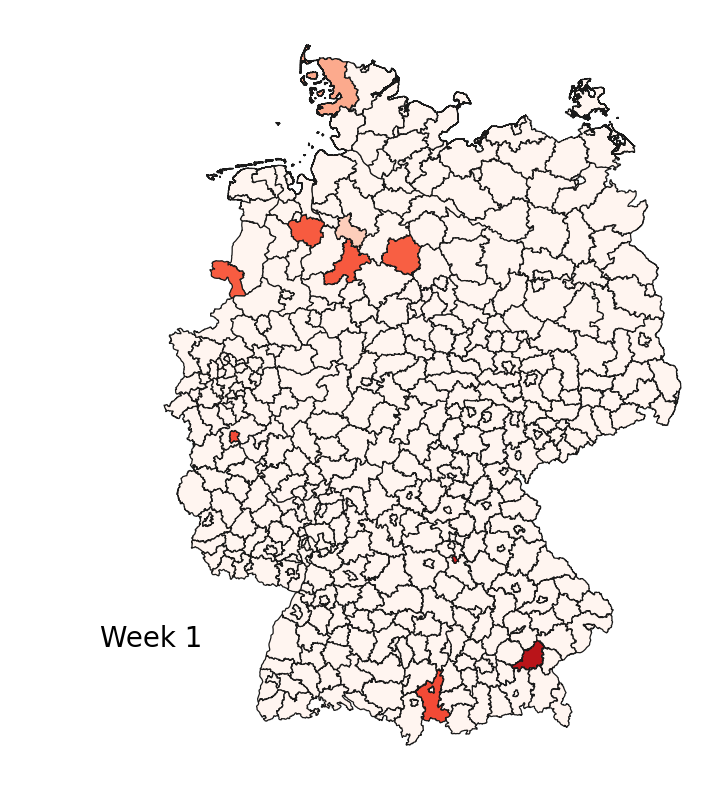

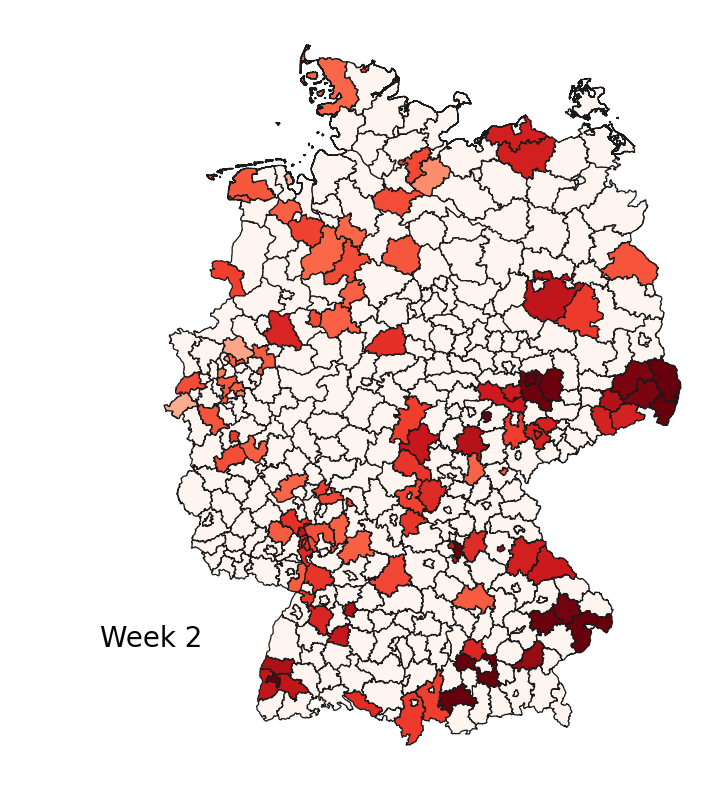

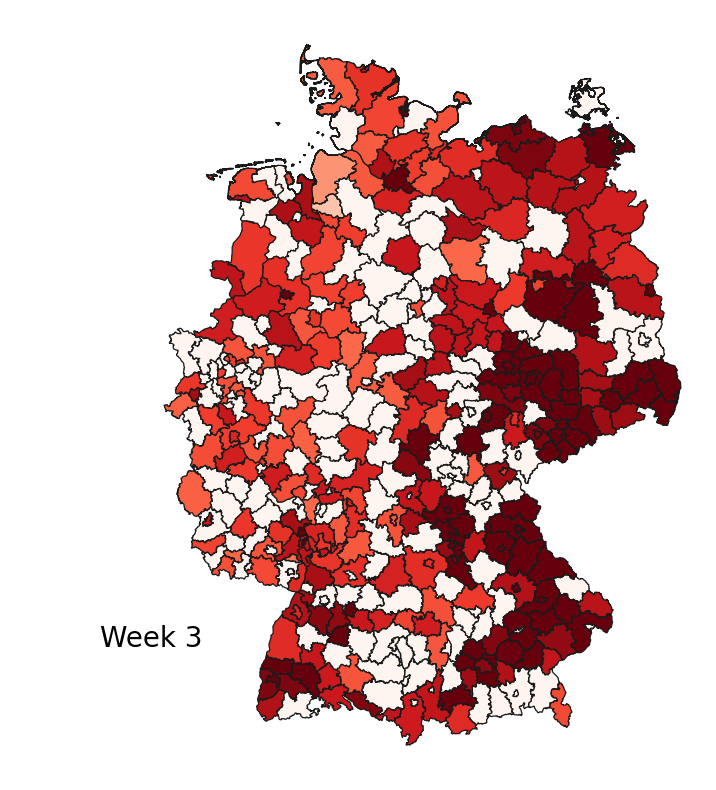

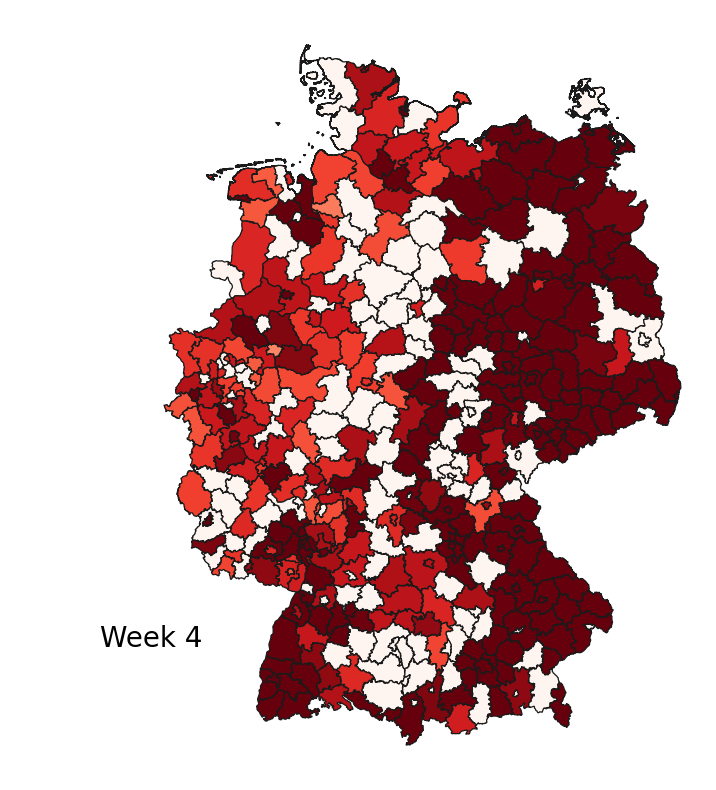

In [23]:
%%time
'''
Draws the flu incidence heatmap for 4 fixed weeks, only coloring weeks the above ruleset.

Other weeks can be selected by changing the bounds on the selected weeks in the initial if-clause
'''

# list of weeks (which are the column names at the moment)
list_of_weeks = sub_gis_flu.columns.tolist()
#remove all strings of SW in the column name
list_of_weeks=[sw.replace('SW', '') for sw in list_of_weeks]


# start the for loop to create one map per year
for week in list_of_weeks:
    
    # only include week of interest - can be changed to output more or different weeks
    if int(week)>25 and int(week)<30:
        norm1 = TwoSlopeNorm(vmin=0, vcenter=2, vmax=25) 

         # color intensity depends on the magnitude of the incidence in that week
        fig = df_flu_gis.plot(column=' SW'+week.strip(), cmap='Reds', figsize=(10,10), linewidth=0.9, edgecolor='0.1',
    legend=False, norm=norm1)

        # remove axis of chart
        fig.axis('off')

        # (Optional) Add prefix of column labels
        if int(week)==26:
            only_week ='Week 1'
        elif int(week)==27:
            only_week='Week 2'
        elif int(week)==28:
            only_week='Week 3'
        elif int(week)==29:
            only_week='Week 4'
            
        # position the annotation to the bottom left
        fig.annotate(only_week,
                xy=(0.1, .165), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                fontsize=20)

        # save the figure as pdf file in the output path
        filepath = os.path.join(res, only_week+'.pdf')
        chart = fig.get_figure()
        chart.savefig(filepath, dpi=100, bbox_inches='tight')
